In [1]:
import gymnasium as gym
from tqdm import tqdm
import numpy as np
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import sinusoid
from tensoraerospace.agent.a2c.narx import Actor, Mish, Critic, A2CLearner, Runner

In [2]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=180, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0]],
                reference_signal=reference_signals,
                output_space = ["theta",  "q",],
                state_space = ["theta", "q",  ],
                tracking_states=["theta"])

# Сброс среды к начальному состоянию
state, info = env.reset()


state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [3]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)

learner = A2CLearner(actor, critic, entropy_beta=0.3)
runner = Runner(env, actor, writer=learner.writer)

In [4]:
steps_on_memory = 1
episodes = 5000
episode_length = 1800
total_steps = (episode_length*episodes)//steps_on_memory

for i in tqdm(range(total_steps)):
    memory = runner.run(steps_on_memory)
    learner.learn(memory, runner.steps, discount_rewards=False)

  100%|██████████| 225000/225000 [41:03:32,00:00:00 19.39it/s]


In [5]:
import torch

# Демонстрация обученного агента
num_demo_episodes = 5

for episode in range(num_demo_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    frames = 0
    prev_action = np.zeros(env.action_space.shape)
    while not done:
        dists = actor(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        actions = dists.sample().detach().data.numpy()
        actions_clipped = np.clip(actions, env.action_space.low.min(), env.action_space.high.max())
        next_state, reward, terminated, truncated, info= env.step(actions_clipped[0])
        prev_action = actions_clipped[0]  # Update the previous action
        done = terminated or truncated
        state = next_state
        total_reward += reward
        state = next_state
        frames +=1
    print(f"Demo Episode {episode}, Total Reward: {total_reward}, {frames}")


# Close the environment
# env.close()


Demo Episode 0, Total Reward: [-43.36014282], 1800
Demo Episode 1, Total Reward: [-32.35950717], 1800
Demo Episode 2, Total Reward: [-31.84462755], 1800
Demo Episode 3, Total Reward: [-35.7489145], 1800
Demo Episode 4, Total Reward: [-40.29492357], 1800


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


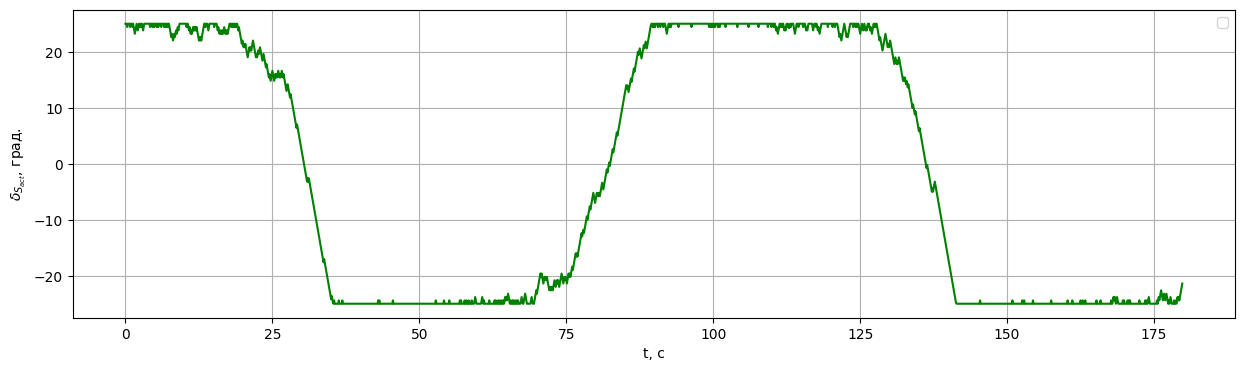

In [6]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

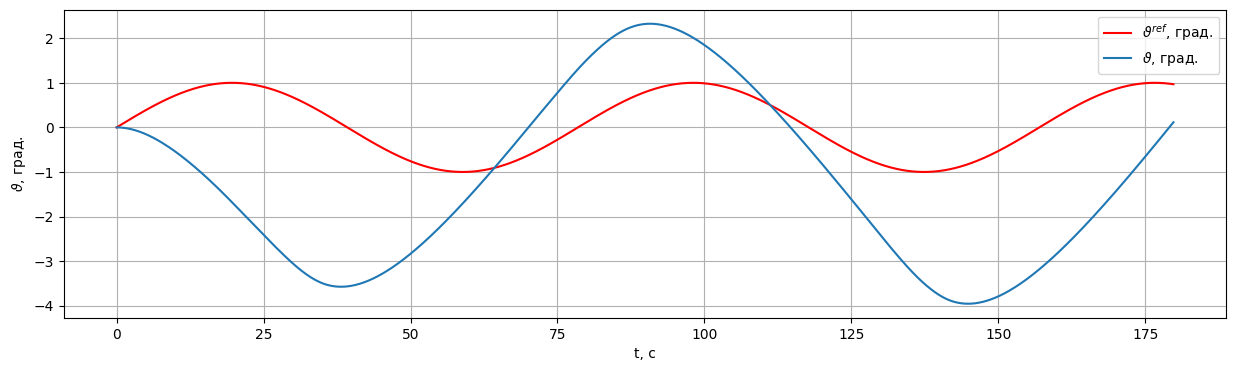

In [7]:
env.unwrapped.model.plot_transient_process('theta', tps, reference_signals[0], to_deg=True, figsize=(15,4))